# **Machine Learning Techniques Project**


*   Nicolas Bedoya Figueroa
*   Daniel Escalante Perez
*   Marilyn Stephany Joven Fonseca
*   Eder Leandro Carbonero Baquero

## **Utils**

In [ ]:
!pip install nltk pyspellchecker tqdm emoji nlpaug transformers tensorflow xgboost[gpu] accelerate

zsh:1: no matches found: xgboost[gpu]


In [ ]:
!pip install seaborn transformers torch tqdm

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!pip install umap-learn plotly

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from spellchecker import SpellChecker
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm
import nlpaug.augmenter.word as naw
from nlpaug.util import Action
import emoji
import random
import math
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eventsequor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/eventsequor/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/eventsequor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eventsequor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/eventsequor/nltk_data...
[nltk_data]   Package averag

True

Librerias ML y DL

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import umap
import plotly.express as px
import ast
import warnings
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier

In [6]:
random_seed = 611
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

## **Data preprocessing**

### **Dataset 1: Davidson et al. 2017**

In [7]:
# Load the dataset
davidson = pd.read_csv("./data/davidson_2017.csv")[["class", "tweet"]]
davidson.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
# Original class labels: 0 - hate speech, 1 - offensive language, 2 - neither
# Transform the label in 1: toxic and 0: non toxic
davidson["class"] = davidson["class"].replace({0: 1, 2: 0})
davidson["class"].value_counts()

class
1    20620
0     4163
Name: count, dtype: int64

In [9]:
print("Rows:", davidson.shape[0])
print("Columns:", davidson.shape[1])

### **Dataset 2: HASOC (2019) English**

In [10]:
hasoc = pd.read_csv("./data/HASOC_EN.tsv",sep = '\t')[["text","task_1"]]
hasoc.head()

,text,task_1
0,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT
1,@politico No. We should remember very clearly ...,HOF
2,@cricketworldcup Guess who would be the winner...,NOT
3,Corbyn is too politically intellectual for #Bo...,NOT
4,All the best to #TeamIndia for another swimmin...,NOT


In [11]:
# Transform the label to 1: toxic and 0: non toxic
hasoc["task_1"] = hasoc["task_1"].replace({"HOF": 1, "NOT": 0})
hasoc["task_1"].value_counts()

/var/folders/xr/_lt8c25j2gzf4trrwlqfnyr00000gn/T/ipykernel_64848/1216868155.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hasoc["task_1"] = hasoc["task_1"].replace({"HOF": 1, "NOT": 0})


task_1
0    3591
1    2261
Name: count, dtype: int64

In [12]:
# Change column names to match the other datasets
hasoc = hasoc.rename(columns={'task_1': 'class', 'text': 'tweet'})
hasoc.head()

,tweet,class
0,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,0
1,@politico No. We should remember very clearly ...,1
2,@cricketworldcup Guess who would be the winner...,0
3,Corbyn is too politically intellectual for #Bo...,0
4,All the best to #TeamIndia for another swimmin...,0


In [13]:
print("Rows:", hasoc.shape[0])
print("Columns:", hasoc.shape[1])

### **Dataset 3: Zeerak Talat’s Hate Speech Dataset**

In [14]:
# Load the dataset
zeerak = pd.read_csv("./data/NAACL_SRW_2016_fixed.csv")[["class", "text"]]
zeerak.head()

,class,text
0,racism,So Drasko just said he was impressed the girls...
1,racism,Drasko they didn't cook half a bird you idiot ...
2,racism,Hopefully someone cooks Drasko in the next ep ...
3,racism,of course you were born in serbia...you're as ...
4,racism,RT @YesYoureRacist: At least you're only a tin...


In [15]:
# Original class labels
zeerak["class"].value_counts()

class
none      7060
sexism    2577
racism      11
Name: count, dtype: int64

In [16]:
# Transform the label to 1: toxic and 0: non toxic
zeerak["class"] = zeerak["class"].replace({"sexism": 1, "racism": 1, "none": 0})
zeerak["class"].value_counts()

/var/folders/xr/_lt8c25j2gzf4trrwlqfnyr00000gn/T/ipykernel_64848/990906760.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  zeerak["class"] = zeerak["class"].replace({"sexism": 1, "racism": 1, "none": 0})


class
0    7060
1    2588
Name: count, dtype: int64

In [17]:
# Rename the columns to match the other datasets
zeerak = zeerak.rename(columns={'text': 'tweet'})
zeerak.head()

,class,tweet
0,1,So Drasko just said he was impressed the girls...
1,1,Drasko they didn't cook half a bird you idiot ...
2,1,Hopefully someone cooks Drasko in the next ep ...
3,1,of course you were born in serbia...you're as ...
4,1,RT @YesYoureRacist: At least you're only a tin...


In [18]:
print("Rows:", zeerak.shape[0])
print("Columns:", zeerak.shape[1])

### **Concatenation**

In [19]:
data = pd.concat([davidson, hasoc, zeerak], axis=0, ignore_index=True)
data.head()

,class,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [20]:
data["class"].value_counts()

class
1    25469
0    14814
Name: count, dtype: int64

In [21]:
print("Rows:", data.shape[0])
print("Columns:", data.shape[1])

### **Cleaning**

In [22]:
#Check point
# Creation of one dataset for embedding of text into a vector and another one for embbeding with GloVe + Twitter
data_cleaning = data.copy()
data_cleaning_slight = data.copy()

In [23]:
# Transform emojis into words

def emoji_to_words(text):
  return emoji.demojize(text, language='en')

data_cleaning['tweet'] = data_cleaning['tweet'].apply(emoji_to_words)
data_cleaning_slight['tweet'] = data_cleaning_slight['tweet'].apply(emoji_to_words)

In [24]:
# Remove URLs from tweets

def remove_urls(text):
  return re.sub(r'http\S+', '', text)

data_cleaning['tweet'] = data_cleaning['tweet'].apply(remove_urls)
data_cleaning_slight['tweet'] = data_cleaning_slight['tweet'].apply(remove_urls)

In [25]:
# Remove mentions from tweets
def remove_mentions(text):
  return re.sub(r'@\w+', '', text)

data_cleaning['tweet'] = data_cleaning['tweet'].apply(remove_mentions)


In [26]:
# Remove symbols from tweets

def leave_letters(text):
  text = re.sub(r'[^a-zA-Z]', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  return text

data_cleaning['tweet'] = data_cleaning['tweet'].apply(leave_letters)

In [27]:
# Remove uncommon symbols from tweets

def clean_tweet_for_glove(text):
  # Keep only letters, numbers, hashtags, mentions, apostrophes, emojis, and basic punctuation
  text = re.sub(r"[^a-zA-Z0-9@#'’!?.,\s]", '', text)  # keep @, #, apostrophes, basic punctuation
  text = re.sub(r'\s+', ' ', text)  # replace multiple spaces with single space
  return text.strip()

data_cleaning_slight['tweet'] = data_cleaning_slight['tweet'].apply(clean_tweet_for_glove)

In [28]:
# Remove symbols from tweets

def lowercase(text):
  return text.lower()

data_cleaning['tweet'] = data_cleaning['tweet'].apply(lowercase)
data_cleaning_slight['tweet'] = data_cleaning_slight['tweet'].apply(lowercase)

In [29]:
# Correct spelling
spell = SpellChecker()

def correct_spelling(text):
  words = text.split()
  corrected_words = [spell.correction(word) or word for word in words]
  return ' '.join(corrected_words)

data_cleaning['tweet'] = [correct_spelling(text) for text in tqdm(data_cleaning['tweet'])]

100%|██████████| 40283/40283 [4:20:35<00:00,  2.58it/s]    


In [30]:
# Remove stopwords

def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))  # Use English stop words
  words = text.split()
  filtered_words = [word for word in words if word not in stop_words]
  return " ".join(filtered_words)

data_cleaning['tweet'] = data_cleaning['tweet'].apply(remove_stopwords)

In [31]:
# Stemming the words

stemmer = PorterStemmer()

def stem_text(text):
  words = text.split()
  stemmed_words = [stemmer.stem(word) for word in words]
  return " ".join(stemmed_words)

In [32]:
data_cleaning['tweet'].head(200)

0      woman complain cleaning house amp man always t...
1             boy days cold toga bad coffin hoe st place
2           dawn ever fuck bitch start cry confused shit
3                                       look like granny
4         shit hear might true might faker bitch told ya
                             ...                        
195    tired bitches saying look mean night big af we...
196    birds grandads may never see thanks climate ch...
197                                 stay beautiful bitch
198    wutkinda r purple ceeeleee man girl playing st...
199          money getting taller bitches getting blurry
Name: tweet, Length: 200, dtype: object

In [33]:
data_cleaning_slight['tweet'].head(200)

0      !!! rt @mayasolovely as a woman you shouldn't ...
1      !!!!! rt @mleew17 boy dats cold...tyga dwn bad...
2      !!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...
3      !!!!!!!!! rt @cganderson @vivabased she look l...
4      !!!!!!!!!!!!! rt @shenikaroberts the shit you ...
                             ...                        
195    @montrell i'm tired of bitches saying i look m...
196    @motherjones 10 birds your grandkids may never...
197                 @mvckfadden stay beautiful you bitch
198    @nickiminaj #wutkinda r purple. ceeeleeeman th...
199    @nastycopper money getting taller and bitches ...
Name: tweet, Length: 200, dtype: object

In [34]:
# Check and remove duplicates
def check_remove_dup(dataset):
  print(f'Duplicates: {dataset["tweet"].duplicated().sum()}')
  duplicated_tweets = dataset["tweet"].duplicated()
  return dataset[~duplicated_tweets]

In [35]:
# Check and remove duplicates in the first dataset

data_cleaning = check_remove_dup(data_cleaning)

In [36]:
# Check and remove duplicates in the second dataset

data_cleaning_slight = check_remove_dup(data_cleaning_slight)


In [ ]:
# Check for null or empty

def check_null_empty(dataset):
  keep = ~((dataset["tweet"].isnull()) | (dataset["tweet"] == ""))

  print(f'Number of nulls or empty: {(~keep).sum()}')

  dataset = dataset[keep]

  print(f'Cleaned data shape: {dataset.shape}')

  return dataset

In [38]:
# Check for null or empty in the first dataset

data_cleaning = check_null_empty(data_cleaning)

In [39]:
# Check for null or empty in the second dataset

data_cleaning_slight = check_null_empty(data_cleaning_slight)

In [40]:
# Checking the dataset's balance

data_cleaning["class"].value_counts()

class
1    24345
0    14114
Name: count, dtype: int64

In [41]:
# Checking the dataset's balance

data_cleaning_slight["class"].value_counts()

class
1    25419
0    14678
Name: count, dtype: int64

In [42]:
# Function to get a random synonym of a word

def get_synonym(word):
  synonyms = []
  for syn in wordnet.synsets(word):
    for lemma in syn.lemmas():
      synonyms.append(lemma.name())
  if len(synonyms) > 0:
    synonyms = list(set(synonyms))
    return synonyms[random.randint(0, len(synonyms) - 1)]
  else:
    return ""

In [43]:
# Custom random insertion function

def random_synonym_insert_augment(text, alpha):

  words = text.split()
  new_text = words.copy()
  for word in words:
    if random.random() < alpha:
      synonym = get_synonym(word)
      if synonym != "":
        position = random.randint(0, len(new_text) - 1)
        new_text.insert(position, synonym)

  return [" ".join(new_text)]

In [44]:
# Balance the data set using easy data augmentation

#Choose an alpha parameter (Percentage of words in a sentence that are changed)
alpha = 0.25

aug_synonym = naw.SynonymAug(aug_src='wordnet', aug_p = alpha)
aug_swap = naw.RandomWordAug(action="swap", aug_p = alpha)
aug_delete = naw.RandomWordAug(action="delete", aug_p = alpha)


def data_augmentation(dataset, alpha):
  # Store the new rows
  new_rows = []

  # Size to balance the classes
  desired_size = len(dataset[dataset['class'] == 1]) - len(dataset[dataset['class'] == 0])

  non_toxic = dataset[dataset['class'] == 0]

  # Until balanced
  while len(new_rows) < desired_size:
    # Get a random sample from the minority class
    random_row = non_toxic.sample(1)

    # Pick a random EDA technique and apply it
    random_num = random.randint(1, 4)
    augmented_text = []

    if random_num == 1:
      augmented_text = aug_synonym.augment(random_row['tweet'].values[0])
    elif random_num == 2:
      augmented_text = aug_swap.augment(random_row['tweet'].values[0])
    elif random_num == 3:
      augmented_text = random_synonym_insert_augment(random_row['tweet'].values[0], alpha)
    else:
      augmented_text = aug_delete.augment(random_row['tweet'].values[0])

    if len(augmented_text) > 0:
      new_rows.append({ "tweet": augmented_text[0], "class": random_row['class'].values[0] })


  # New rows dataframe
  new_rows_df = pd.DataFrame(new_rows)

  # Concatenate the datasets
  return pd.concat([dataset, new_rows_df], ignore_index = True, axis = 0)

In [45]:
# Balance the first dataset

balanced_data = data_augmentation(data_cleaning, alpha)

print(f'Balanced data shape: {balanced_data.shape}')
print()
balanced_data["class"].value_counts()


Balanced data shape: (48690, 2)



class
0    24345
1    24345
Name: count, dtype: int64

In [46]:
# Balance the second dataset

balanced_data_glove = data_augmentation(data_cleaning_slight, alpha)

print(f'Balanced data shape: {balanced_data_glove.shape}')
print()
balanced_data_glove["class"].value_counts()

Balanced data shape: (50838, 2)



class
0    25419
1    25419
Name: count, dtype: int64

In [47]:
# Check and remove duplicates again that could have appeared due to augmentation

balanced_data = check_remove_dup(balanced_data)

Duplicates: 973


In [48]:
# Check and remove duplicates again that could have appeared due to augmentation in the second dataset

balanced_data_glove = check_remove_dup(balanced_data_glove)

Duplicates: 692


In [49]:
# Check for null or empty again if they appeared due to augmentation

balanced_data = check_null_empty(balanced_data)

Number of nulls or empty: 0
Cleaned data shape: (47717, 2)


In [50]:
# Check for null or empty again if they appeared due to augmentation in the second dataset

balanced_data_glove = check_null_empty(balanced_data_glove)

Number of nulls or empty: 0
Cleaned data shape: (50146, 2)


In [51]:
# Final distribution

balanced_data["class"].value_counts()

class
1    24345
0    23372
Name: count, dtype: int64

In [52]:
# Final distribution

balanced_data_glove["class"].value_counts()

class
1    25419
0    24727
Name: count, dtype: int64

In [53]:
balanced_data.to_csv('balanced_data.csv', index=False)

In [54]:
balanced_data_glove.to_csv('balanced_data_glove.csv', index=False)

## **Embeddings Secuenciales roBERTa Twitter**

In [55]:
# Setting the device to use GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

In [56]:
# Instanciating pre trained model

model_name = "cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()
model.to(device)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [57]:
# Reading the stored data

data = pd.read_csv('balanced_data.csv')
tweets = data['tweet'].astype(str).values

In [ ]:
# Generating the embeddings

embeddings = []

for tweet in tqdm(tweets, desc = "Generando embeddings..."):
    inputs = tokenizer(tweet, padding='max_length', max_length=32, truncation = True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings.append(outputs.last_hidden_state.squeeze(0))

embeddings_tensor = torch.stack(embeddings).cpu().numpy()


Generando embeddings...: 100%|██████████| 47717/47717 [13:24<00:00, 59.33it/s]


In [59]:
# Storing the embeddings

np.save('embeddings_data_sequencial.npy', embeddings_tensor)

## **Embeddings Contextuales BERT**

In [60]:
model_name = 'cardiffnlp/twitter-roberta-base'
max_len = 64

tokenizer_roberta = AutoTokenizer.from_pretrained(model_name)
model_roberta = AutoModel.from_pretrained(model_name)
model_roberta.eval()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [62]:
data = pd.read_csv('balanced_data.csv')
tweets = data['tweet'].astype(str).tolist()

In [63]:
def mean_pooling(outputs, attention_mask):
    token_embeddings = outputs.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
    sum_mask = input_mask_expanded.sum(1)
    return sum_embeddings / sum_mask

In [ ]:
def generate_embeddings(texts, model, tokenizer, max_len=64, device=None):

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    embeddings_cls = []
    embeddings_mean = []

    for text in tqdm(texts, desc='Generando embeddings'):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=max_len)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)

        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
        embeddings_cls.append(cls_embedding)

        mean_embedding = mean_pooling(outputs, inputs['attention_mask']).squeeze().cpu().numpy()
        embeddings_mean.append(mean_embedding)

    return embeddings_cls, embeddings_mean

In [65]:
embeddings_cls, embeddings_mean = generate_embeddings(tweets, model_roberta, tokenizer_roberta, max_len)

data["embedding_cls"] = [vec.tolist() for vec in embeddings_cls]
data["embedding_mean"] = [vec.tolist() for vec in embeddings_mean]

data.to_csv('data/embeddings_data.csv',index=False)

Generando embeddings: 100%|██████████| 47705/47705 [25:59<00:00, 30.59it/s]    


In [66]:
!pip3 install --upgrade nbformat

/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
df = pd.read_csv("data/embeddings_data.csv")
df["embedding_mean"] = df["embedding_mean"].apply(ast.literal_eval)
X = np.vstack(df["embedding_mean"].values)
labels = df["class"].astype(str) if "class" in df.columns else None

reducer = umap.UMAP(n_components=3, random_state=42)
X_umap = reducer.fit_transform(X)

fig = px.scatter_3d(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    z=X_umap[:, 2],
    color=labels,
    title="UMAP 3D de embeddings de tweets",
    labels={"color": "Clase"}
)
fig.show()

## **Machine Learning Models**

### **Nicolas Bedoya Figueroa**

### **Daniel Escalante Perez**

#### **XGBClassifier**

In [68]:
# Loading the embedded data

data = pd.read_csv("data/embeddings_data.csv")

In [69]:
data.shape

(47705, 4)

In [70]:
# Splitting the characteristics and label

X = np.vstack([np.array(ast.literal_eval(vec), dtype=float) for vec in data["embedding_cls"]])
y = data["class"].values

In [71]:
# Splitting the train and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=611, shuffle = True)

In [72]:
X_train.shape

(38164, 768)

In [73]:
# Parameter exploration grid
param_grid = {
    "n_estimators": [450, 500, 550],
    "max_depth": [10, 20, 50],
    "min_child_weight": [10, 5, 2]
}

# Grid search configuration
characteristics = math.sqrt(X_train.shape[1]) / X_train.shape[1]
model = XGBClassifier(tree_method="hist", device="cuda", subsample = 0.8, colsample_bytree = characteristics, colsample_bynode = characteristics)
grid_search = GridSearchCV(model, param_grid, scoring = "accuracy", n_jobs = 2, cv = 3, verbose = 3, return_train_score = True)

In [74]:
# Train the model and search for the hyperparameters with 50% of the whole set, theres no enough GPU memory for the whole training set
grid_search.fit(X_train[:25000], y_train[:25000])

Fitting 3 folds for each of 27 candidates, totalling 81 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/eventsequor/Library/P

[CV 1/3] END max_depth=10, min_child_weight=10, n_estimators=450;, score=(train=1.000, test=0.849) total time=  13.6s
[CV 2/3] END max_depth=10, min_child_weight=10, n_estimators=450;, score=(train=1.000, test=0.844) total time=  13.7s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:14:20] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:14:20] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=10, n_estimators=450;, score=(train=1.000, test=0.842) total time=  13.3s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 1/3] END max_depth=10, min_child_weight=10, n_estimators=500;, score=(train=1.000, test=0.853) total time=  14.0s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:14:34] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:14:35] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=10, n_estimators=500;, score=(train=1.000, test=0.844) total time=  14.3s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 3/3] END max_depth=10, min_child_weight=10, n_estimators=500;, score=(train=1.000, test=0.846) total time=  13.8s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:14:49] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:14:50] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=10, n_estimators=550;, score=(train=1.000, test=0.852) total time=  15.4s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 2/3] END max_depth=10, min_child_weight=10, n_estimators=550;, score=(train=1.000, test=0.843) total time=  14.6s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:15:05] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:15:06] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=5, n_estimators=450;, score=(train=1.000, test=0.849) total time=  14.1s
[CV 3/3] END max_depth=10, min_child_weight=10, n_estimators=550;, score=(train=1.000, test=0.847) total time=  15.4s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:15:20] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:15:21] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=5, n_estimators=450;, score=(train=1.000, test=0.849) total time=  15.0s
[CV 3/3] END max_depth=10, min_child_weight=5, n_estimators=450;, score=(train=1.000, test=0.847) total time=  14.9s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:15:36] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:15:36] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=5, n_estimators=500;, score=(train=1.000, test=0.849) total time=  16.5s
[CV 1/3] END max_depth=10, min_child_weight=5, n_estimators=500;, score=(train=1.000, test=0.850) total time=  16.7s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:15:52] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:15:52] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=5, n_estimators=500;, score=(train=1.000, test=0.849) total time=  17.5s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:16:10] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=5, n_estimators=550;, score=(train=1.000, test=0.851) total time=  18.9s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:16:12] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=5, n_estimators=550;, score=(train=1.000, test=0.849) total time=  17.3s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:16:27] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=5, n_estimators=550;, score=(train=1.000, test=0.850) total time=  16.9s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:16:28] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=2, n_estimators=450;, score=(train=1.000, test=0.852) total time=  16.1s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:16:43] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=2, n_estimators=450;, score=(train=1.000, test=0.851) total time=  15.5s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:16:44] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=2, n_estimators=450;, score=(train=1.000, test=0.850) total time=  16.1s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:17:00] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=10, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.852) total time=  17.2s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:17:01] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.852) total time=  17.0s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 3/3] END max_depth=10, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.851) total time=  16.3s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:17:18] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:17:19] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=10, min_child_weight=2, n_estimators=550;, score=(train=1.000, test=0.854) total time=  18.0s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 1/3] END max_depth=10, min_child_weight=2, n_estimators=550;, score=(train=1.000, test=0.855) total time=  17.5s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:17:36] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:17:38] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=10, min_child_weight=2, n_estimators=550;, score=(train=1.000, test=0.852) total time=  16.4s
[CV 1/3] END max_depth=20, min_child_weight=10, n_estimators=450;, score=(train=1.000, test=0.854) total time=  14.9s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:17:53] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:17:53] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=20, min_child_weight=10, n_estimators=450;, score=(train=1.000, test=0.847) total time=  14.0s
[CV 3/3] END max_depth=20, min_child_weight=10, n_estimators=450;, score=(train=1.000, test=0.847) total time=  14.1s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:18:07] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:18:07] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=20, min_child_weight=10, n_estimators=500;, score=(train=1.000, test=0.855) total time=  15.2s
[CV 2/3] END max_depth=20, min_child_weight=10, n_estimators=500;, score=(train=1.000, test=0.848) total time=  15.1s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:18:22] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:18:24] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=20, min_child_weight=10, n_estimators=500;, score=(train=1.000, test=0.848) total time=  14.8s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:18:37] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=20, min_child_weight=10, n_estimators=550;, score=(train=1.000, test=0.856) total time=  16.1s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:18:40] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=20, min_child_weight=10, n_estimators=550;, score=(train=1.000, test=0.847) total time=  16.3s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[CV 3/3] END max_depth=20, min_child_weight=10, n_estimators=550;, score=(train=1.000, test=0.848) total time=  15.1s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:18:56] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:18:56] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=20, min_child_weight=5, n_estimators=450;, score=(train=1.000, test=0.848) total time=  17.5s
[CV 1/3] END max_depth=20, min_child_weight=5, n_estimators=450;, score=(train=1.000, test=0.853) total time=  17.8s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:19:13] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:19:14] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=20, min_child_weight=5, n_estimators=450;, score=(train=1.000, test=0.849) total time=  17.8s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:19:31] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=20, min_child_weight=5, n_estimators=500;, score=(train=1.000, test=0.853) total time=  18.8s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:19:33] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=20, min_child_weight=5, n_estimators=500;, score=(train=1.000, test=0.850) total time=  17.9s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=20, min_child_weight=5, n_estimators=500;, score=(train=1.000, test=0.850) total time=  18.2s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:19:51] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=20, min_child_weight=5, n_estimators=550;, score=(train=1.000, test=0.853) total time=  19.1s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:20:08] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=20, min_child_weight=5, n_estimators=550;, score=(train=1.000, test=0.849) total time=  18.7s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:20:10] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=20, min_child_weight=5, n_estimators=550;, score=(train=1.000, test=0.851) total time=  20.9s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:20:29] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=20, min_child_weight=2, n_estimators=450;, score=(train=1.000, test=0.855) total time=  23.3s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:20:33] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=20, min_child_weight=2, n_estimators=450;, score=(train=1.000, test=0.849) total time=  29.2s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:20:59] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=20, min_child_weight=2, n_estimators=450;, score=(train=1.000, test=0.847) total time=  29.3s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:21:03] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=20, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.856) total time=  32.0s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:21:31] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=20, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.847) total time=  31.6s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:21:34] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=20, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.850) total time=  31.5s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:22:03] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=20, min_child_weight=2, n_estimators=550;, score=(train=1.000, test=0.857) total time=  32.4s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:22:07] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=20, min_child_weight=2, n_estimators=550;, score=(train=1.000, test=0.848) total time=  24.3s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:22:27] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=20, min_child_weight=2, n_estimators=550;, score=(train=1.000, test=0.851) total time=  24.0s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:22:31] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=50, min_child_weight=10, n_estimators=450;, score=(train=1.000, test=0.853) total time=  14.7s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:22:42] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=50, min_child_weight=10, n_estimators=450;, score=(train=1.000, test=0.845) total time=  14.2s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:22:47] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=50, min_child_weight=10, n_estimators=450;, score=(train=1.000, test=0.845) total time=  14.1s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:22:58] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=50, min_child_weight=10, n_estimators=500;, score=(train=1.000, test=0.854) total time=  14.7s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:23:02] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=50, min_child_weight=10, n_estimators=500;, score=(train=1.000, test=0.846) total time=  15.1s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:23:13] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=50, min_child_weight=10, n_estimators=500;, score=(train=1.000, test=0.847) total time=  15.2s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:23:17] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=50, min_child_weight=10, n_estimators=550;, score=(train=1.000, test=0.854) total time=  16.3s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:23:29] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=50, min_child_weight=10, n_estimators=550;, score=(train=1.000, test=0.847) total time=  16.1s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:23:33] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=50, min_child_weight=10, n_estimators=550;, score=(train=1.000, test=0.847) total time=  16.6s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:23:46] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=50, min_child_weight=5, n_estimators=450;, score=(train=1.000, test=0.848) total time=  16.8s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:23:50] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=50, min_child_weight=5, n_estimators=450;, score=(train=1.000, test=0.847) total time=  16.9s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:24:03] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=50, min_child_weight=5, n_estimators=450;, score=(train=1.000, test=0.847) total time=  16.8s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:24:07] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=50, min_child_weight=5, n_estimators=500;, score=(train=1.000, test=0.849) total time=  18.0s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:24:21] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=50, min_child_weight=5, n_estimators=500;, score=(train=1.000, test=0.848) total time=  17.8s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:24:25] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=50, min_child_weight=5, n_estimators=500;, score=(train=1.000, test=0.847) total time=  18.2s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:24:39] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=50, min_child_weight=5, n_estimators=550;, score=(train=1.000, test=0.850) total time=  19.6s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:24:45] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=50, min_child_weight=5, n_estimators=550;, score=(train=1.000, test=0.849) total time=  18.8s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:24:58] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=50, min_child_weight=5, n_estimators=550;, score=(train=1.000, test=0.848) total time=  19.9s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:25:05] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=50, min_child_weight=2, n_estimators=450;, score=(train=1.000, test=0.856) total time=  22.5s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:25:21] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=50, min_child_weight=2, n_estimators=450;, score=(train=1.000, test=0.851) total time=  21.9s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:25:27] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=50, min_child_weight=2, n_estimators=450;, score=(train=1.000, test=0.850) total time=  22.9s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:25:44] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=50, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.856) total time=  23.5s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:25:51] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=50, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.850) total time=  23.7s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:26:08] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 3/3] END max_depth=50, min_child_weight=2, n_estimators=500;, score=(train=1.000, test=0.850) total time=  23.2s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:26:14] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 1/3] END max_depth=50, min_child_weight=2, n_estimators=550;, score=(train=1.000, test=0.858) total time=  25.1s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [08:26:33] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[CV 2/3] END max_depth=50, min_child_weight=2, n_estimators=550;, score=(train=1.000, test=0.850) total time=  24.4s
[CV 3/3] END max_depth=50, min_child_weight=2, n_estimators=550;, score=(train=1.000, test=0.853) total time=  16.0s


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning:

[08:26:49] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.



GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=0.03608439182435161,
                                     colsample_bytree=0.03608439182435161,
                                     device='cuda', early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_cons...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=2,
             param_grid={'max_depth': [10, 20, 50],
                         'min_child_weight': [10, 5, 2],
                         'n_estimators': [450, 500, 550]},
             return_train_score=True, scoring='accuracy', verbose=3)

In [75]:
grid_search.best_params_

{'max_depth': 50, 'min_child_weight': 2, 'n_estimators': 550}

In [76]:
grid_search.best_score_

0.8536398235387059

In [77]:
# Creation of the final model
model = XGBClassifier(tree_method="hist", device="cuda", subsample = 0.8, colsample_bytree = characteristics, colsample_bynode = characteristics, n_estimators = 500, max_depth = 20, min_child_weight = 20)

In [78]:
model.fit(X_train, y_train)

/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning:

[08:27:18] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.03608439182435161,
              colsample_bytree=0.03608439182435161, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=20, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      4637
           1       0.88      0.82      0.85      4904

    accuracy                           0.85      9541
   macro avg       0.85      0.85      0.85      9541
weighted avg       0.85      0.85      0.85      9541



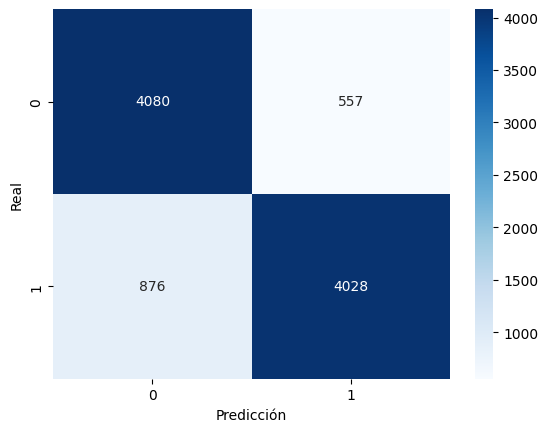

In [79]:
# Evaluation of the model

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, xticklabels = ["0", "1"], yticklabels = ["0", "1"], annot=True, cmap='Blues', fmt = 'g')
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()


### **Marilyn Stephany Joven Fonseca**

#### Naive Bayes

In [80]:
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [81]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b\w{1,2}\b', '', text)
    return text

X_text = df['tweet'].apply(clean_text)

In [82]:
y = df['class']

vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_text)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      4654
           1       0.84      0.86      0.85      4887

    accuracy                           0.85      9541
   macro avg       0.85      0.85      0.85      9541
weighted avg       0.85      0.85      0.85      9541



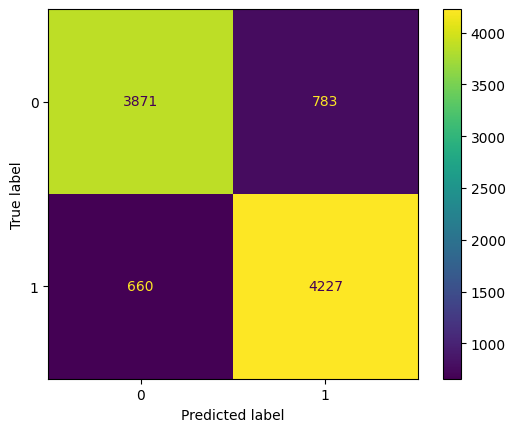

In [83]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

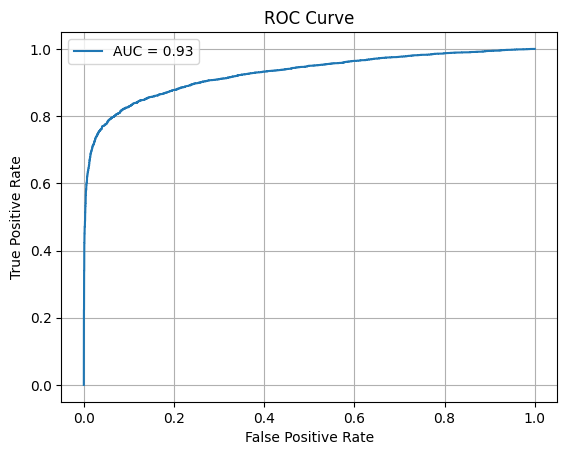

In [84]:
y_prob = nb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

### **Eder Leandro Carbonero Baquero**

Regression logistica
 Red neuronal convolucional CNN

#### Logistic regression

##### Carga de datos

In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# === 1. CARGAR DATOS ===
df_rg = pd.read_csv('data/embeddings_data.csv')  # ← Archivo fuente

# Convertir la columna embedding_mean de string a lista de floats
df_rg['embedding_mean'] = df_rg['embedding_mean'].apply(ast.literal_eval)

# === 2. PREPARAR FEATURES Y LABELS ===
X = np.vstack(df_rg['embedding_mean'].values)  # (n_samples, 768)
y = df_rg['class'].values

In [86]:
# === 3. DIVIDIR EN TRAIN Y TEST ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 4. ENTRENAR MODELO DE REGRESIÓN LOGÍSTICA ===
log_reg_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)
log_reg_model.fit(X_train, y_train)

# === 5. PREDICCIONES Y MÉTRICAS ===
y_pred = log_reg_model.predict(X_test)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir métricas
print(f"Accuracy: {accuracy:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Accuracy: 0.8627
Precisión: 0.8980
Recall: 0.8246
F1-score: 0.8597


In [87]:
# === 6. GUARDAR MÉTRICAS EN UN CSV ===

# Crear un DataFrame con las métricas
metrics_df = pd.DataFrame({
    'modelo': ['Regresión Logística'],
    'accuracy': [accuracy],
    'precision': [precision],
    'recall': [recall],
    'f1_score': [f1]
})

# Guardar en un archivo
metrics_df.to_csv('resultados_metricas.csv', index=False)

print("Métricas guardadas en 'resultados_metricas.csv'")

Métricas guardadas en 'resultados_metricas.csv'


In [88]:
import joblib

# Guardar el modelo entrenado
joblib.dump(log_reg_model, 'modelo_regresion_logistica.pkl')

print("Modelo guardado en 'modelo_regresion_logistica.pkl'")

Modelo guardado en 'modelo_regresion_logistica.pkl'


In [89]:
# Cargar el modelo desde el archivo
modelo_cargado = joblib.load('modelo_regresion_logistica.pkl')

# Usar el modelo cargado para hacer predicciones
nuevas_preds = modelo_cargado.predict(X_test)  # Por ejemplo, sobre X_test

##### Modelo de prediccón a partir de una sentencia

In [90]:
!pip install transformers torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import joblib
import numpy as np

# === 1. CARGAR MODELOS ===
# Cargar modelo y tokenizer de CardiffNLP
model_name = 'cardiffnlp/twitter-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
embedding_model = AutoModel.from_pretrained(model_name)

# Cargar el modelo de regresión logística previamente guardado
modelo_clasificador = joblib.load('modelo_regresion_logistica.pkl')

# === 2. DEFINIR MÉTODO PARA PREDECIR ===
def predict_hate_speech(frase):
    # Tokenizar entrada
    inputs = tokenizer(
        frase,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128  # ← Agregado para evitar warnings
    )

    # Obtener embedding
    with torch.no_grad():
        outputs = embedding_model(**inputs)

    # Mean pooling
    last_hidden_state = outputs.last_hidden_state
    embedding_mean = last_hidden_state.mean(dim=1).numpy()

    # Predecir
    pred = modelo_clasificador.predict(embedding_mean)[0]

    # Interpretar predicción
    return "Hate Speech ⚠️" if pred == 1 else "No Hate Speech ✅"


In [92]:
frase = "I hate you so much!"
resultado = predict_hate_speech(frase)
print(resultado)

No Hate Speech ✅


In [93]:
# Acceder a los coeficientes de la regresión logística
coeficientes = modelo_clasificador.coef_[0]  # (768,)

# Ordenar dimensiones por importancia
importancia_dims = np.argsort(coeficientes)[::-1]  # Mayor a menor

# Mostrar las 10 dimensiones más relacionadas con hate
print("Top 10 dimensiones más asociadas a hate speech:")
for idx in importancia_dims[:10]:
    print(f"Dimensión {idx} → Peso: {coeficientes[idx]:.4f}")


Top 10 dimensiones más asociadas a hate speech:
Dimensión 237 → Peso: 2.3100
Dimensión 182 → Peso: 2.3013
Dimensión 428 → Peso: 2.2513
Dimensión 2 → Peso: 2.0184
Dimensión 746 → Peso: 1.9581
Dimensión 393 → Peso: 1.8526
Dimensión 719 → Peso: 1.7818
Dimensión 638 → Peso: 1.7315
Dimensión 744 → Peso: 1.7248
Dimensión 81 → Peso: 1.7032


In [94]:
from transformers import RobertaTokenizer

# Cargar el tokenizador de RoBERTa
tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base')

# Acceder a los coeficientes de la regresión logística
coeficientes = modelo_clasificador.coef_[0]  # (768,)

# Ordenar dimensiones por importancia
importancia_dims = np.argsort(coeficientes)[::-1]  # Mayor a menor

# Mostrar las 10 palabras más asociadas a hate speech
print("Top 10 tokens más asociados a hate speech:")
for idx in importancia_dims[:10]:
    # Obtener el token asociado a esta dimensión
    token_id = idx  # El índice aquí corresponde al token ID de RoBERTa
    token = tokenizer.decode([token_id])  # Decodificar el token a una palabra/fragmento
    print(f"Token: {token} → Coeficiente: {coeficientes[idx]:.4f}")


Top 10 tokens más asociados a hate speech:
Token:  four → Coeficiente: 2.3100
Token:  very → Coeficiente: 2.3013
Token: b → Coeficiente: 2.2513
Token: </s> → Coeficiente: 2.0184
Token:  total → Coeficiente: 1.9581
Token:  never → Coeficiente: 1.8526
Token:  December → Coeficiente: 1.7818
Token:  record → Coeficiente: 1.7315
Token:  death → Coeficiente: 1.7248
Token:  over → Coeficiente: 1.7032


## **Deep Learning Models**

### **Nicolas Bedoya Figueroa**

### **Daniel Escalante Perez**

#### **Utils**

In [95]:
# Function for measuring the accuracy

def get_accuracy(output, y, train_size):
    pred = torch.sigmoid(output) > 0.5  # Thresholding
    correct = pred.eq(y.bool()).sum().item()
    return correct / train_size

In [96]:
# Training function

def train(train_loader, optimizer, loss_function, model_train):
    loss = 0
    accuracy = 0
    batch_num = 0
    model_train.train()
    for x, y in train_loader:
        batch_num += 1
        output = model_train(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_accuracy(output, y, len(train_loader.dataset))
    print(f"Train Loss: {round(loss/batch_num, 5)}, Train Accuracy: {round(accuracy, 5)}")

    return loss/batch_num, accuracy

In [97]:
# Validation function

def validate(val_loader, loss_function, model_val):

    loss = 0
    accuracy = 0
    batch_num = 0

    model_val.eval()
    with torch.no_grad():
        for x, y in val_loader:
            batch_num += 1
            output = model_val(x)
            batch_loss = loss_function(output, y)

            loss += batch_loss.item()
            accuracy += get_accuracy(output, y, len(val_loader.dataset))
    print(f"Validation Loss: {round(loss/batch_num, 5)}, Validation Accuracy: {round(accuracy, 5)}")
    return loss/batch_num, accuracy

In [ ]:
# Saving the best model

def save_checkpoint(model_save):
    torch.save(model_save.state_dict(), "best_model.pth")


In [ ]:
# Loading the best model

def load_checkpoint(model_load):
    checkpoint = torch.load("best_model.pth", map_location=device)
    checkpoint = { k.replace("_orig_mod.", ""): v for k, v in checkpoint.items() }
    model_load.load_state_dict(checkpoint)
    model_load = torch.compile(model_load.to(device), backend="eager")
    model_load.eval()
    return model_load


In [ ]:
# Loss and accuracy graphing

def loss_accuracy_graph(loss_accuracy_list):
    epochs = len(loss_accuracy_list)
    train_loss = [loss_accuracy_list[i][0] for i in range(epochs)]
    train_accuracy = [loss_accuracy_list[i][1] for i in range(epochs)]
    val_loss = [loss_accuracy_list[i][2] for i in range(epochs)]
    val_accuracy = [loss_accuracy_list[i][3] for i in range(epochs)]

    plt.plot(range(1, epochs + 1), train_loss, 'r-', label = "Training")
    plt.plot(range(1, epochs + 1), val_loss, 'b-', label = "Validation")
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.show()

    plt.plot(range(1, epochs + 1), train_accuracy, 'r-', label = "Training")
    plt.plot(range(1, epochs + 1), val_accuracy, 'b-', label = "Validation")
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.show()


In [ ]:
# Training loop

def training_loop(epochs, train_loader, val_loader, optimizer, loss_function, model_train_loop):
    max_accuracy = float("-inf")
    loss_accuracy_list = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss, train_accuracy = train(train_loader, optimizer, loss_function, model_train_loop)
        current_loss, val_accuracy = validate(val_loader, loss_function, model_train_loop)
        loss_accuracy_list.append((train_loss, train_accuracy, current_loss, val_accuracy))
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy
            save_checkpoint(model_train_loop)
            print("Model saved!")
        else:
            print("Model not saved!")

    loss_accuracy_graph(loss_accuracy_list)

In [102]:
# Model evaluation

def evaluate_model(model_load, X_test, y_test):
    model_eval = load_checkpoint(model_load)

    with torch.no_grad():
        y_pred = model_eval(torch.tensor(X_test).float().to(device))

    pred = torch.sigmoid(y_pred).cpu().numpy() > 0.5

    print(classification_report(y_test, pred))

    conf_matrix = confusion_matrix(y_test, pred)

    sns.heatmap(conf_matrix, xticklabels = ["0", "1"], yticklabels = ["0", "1"], annot=True, cmap='Blues', fmt = 'g')
    plt.ylabel("Real")
    plt.xlabel("Predicción")
    plt.show()

#### **BI-LSTM**

In [103]:
# Check GPU availability

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

In [108]:
# Embedding loading
X = np.load("embeddings_data_sequencial.npy")
X.shape

(47717, 32, 768)

In [109]:
# Labels loading
data = pd.read_csv("balanced_data.csv")
y = data["class"].values
y.shape

(47717,)

In [110]:
# Shuffling the dataset

permutation = np.random.permutation(len(y))
y = y[permutation].reshape(-1, 1)
X = X[permutation]

In [111]:
# Calculation of the set distribution

test_size = int(y.shape[0] * 0.15)
val_size = int(y.shape[0] * 0.15)
train_size = int(y.shape[0] * 0.7)

In [112]:
# Set definition

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size : ]
y_test = y[train_size + val_size : ]

In [ ]:
# Custom layer that takes the last hidden state of the sequences

class Modifier(nn.Module):
    def __init__(self):
        super().__init__()


    def forward(self, x):
        output = x[:,-1,:]

        return output

In [114]:
# Custom dataset class

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.xs = torch.tensor(x).float().to(device)
        self.ys = torch.tensor(y).float().to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

In [115]:
# Creation of the custom training and validation datasets

train_data = CustomDataset(X_train, y_train)
val_data = CustomDataset(X_val, y_val)

In [116]:
# Creation of the dataloaders

train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_data, batch_size = 32, shuffle = True)

In [117]:
# Loader testing

x_batch, y_batch = next(iter(train_loader))
x_batch.shape

torch.Size([32, 32, 768])

In [ ]:
# Custom layer that takes the last hidden state of the sequences

class Modifier(nn.Module):
    def __init__(self):
        super().__init__()


    def forward(self, x):
        output = x[:,-1,:]

        return output

In [ ]:
# Model architecture definition

class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size = 768, hidden_size = 256, num_layers = 1, batch_first = True, bidirectional=True)
        self.dropout = nn.Dropout(p = 0.3)
        self.lstm2 = nn.LSTM(input_size = 512, hidden_size = 128, num_layers = 1, batch_first = True, bidirectional=True)
        self.modifier = Modifier()
        self.dropout2 = nn.Dropout(p = 0.3)

        self.linear = nn.Linear(256, 64)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(64, 1)


    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.dropout(lstm_out)
        lstm_out, _ = self.lstm2(x)
        x = self.modifier(lstm_out)
        x = self.dropout2(x)

        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)

        return x

model = CustomModel()

In [120]:
# Model compilation

model = torch.compile(model.to(device), backend="eager")
model

OptimizedModule(
  (_orig_mod): CustomModel(
    (lstm): LSTM(768, 256, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (lstm2): LSTM(512, 128, batch_first=True, bidirectional=True)
    (modifier): Modifier()
    (dropout2): Dropout(p=0.3, inplace=False)
    (linear): Linear(in_features=256, out_features=64, bias=True)
    (relu): ReLU()
    (linear2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [121]:
# Loss and optimizer definition

loss_function = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters())
model = model.to(device)

Epoch 1/200
Train Loss: 0.36267, Train Accuracy: 0.84267
Validation Loss: 0.31598, Validation Accuracy: 0.8709
Model saved!
Epoch 2/200
Train Loss: 0.2937, Train Accuracy: 0.87518
Validation Loss: 0.28397, Validation Accuracy: 0.87914
Model saved!
Epoch 3/200
Train Loss: 0.26927, Train Accuracy: 0.88878
Validation Loss: 0.29341, Validation Accuracy: 0.88151
Model saved!
Epoch 4/200
Train Loss: 0.24648, Train Accuracy: 0.89985
Validation Loss: 0.28001, Validation Accuracy: 0.88543
Model saved!
Epoch 5/200
Train Loss: 0.22341, Train Accuracy: 0.91105
Validation Loss: 0.28516, Validation Accuracy: 0.88235
Model not saved!
Epoch 6/200
Train Loss: 0.19119, Train Accuracy: 0.92569
Validation Loss: 0.29976, Validation Accuracy: 0.88696
Model saved!
Epoch 7/200
Train Loss: 0.16134, Train Accuracy: 0.93856
Validation Loss: 0.30169, Validation Accuracy: 0.88599
Model not saved!
Epoch 8/200
Train Loss: 0.12749, Train Accuracy: 0.95279
Validation Loss: 0.41005, Validation Accuracy: 0.88738
Model s

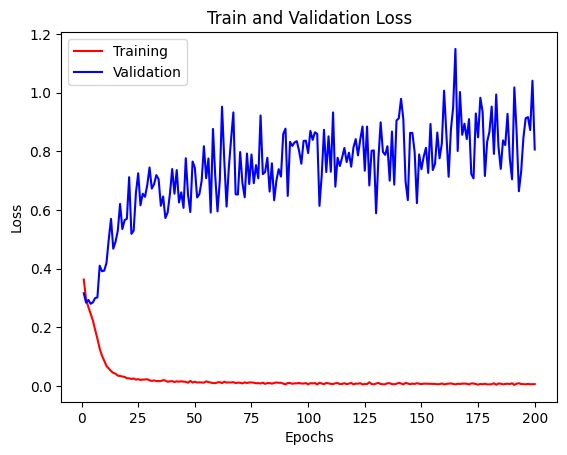

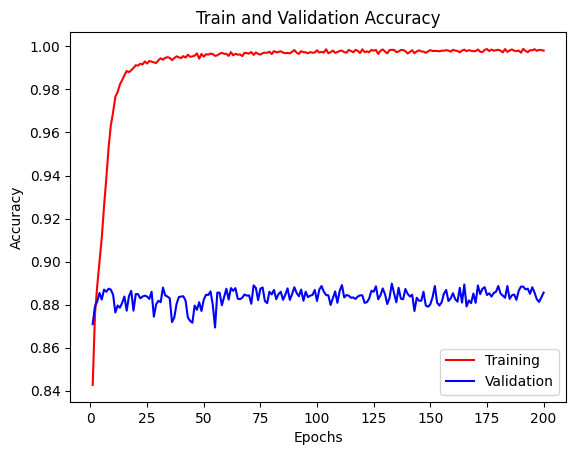

In [122]:
training_loop(200, train_loader, val_loader, optimizer, loss_function, model)

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3459
           1       0.94      0.84      0.89      3700

    accuracy                           0.89      7159
   macro avg       0.89      0.89      0.89      7159
weighted avg       0.89      0.89      0.89      7159



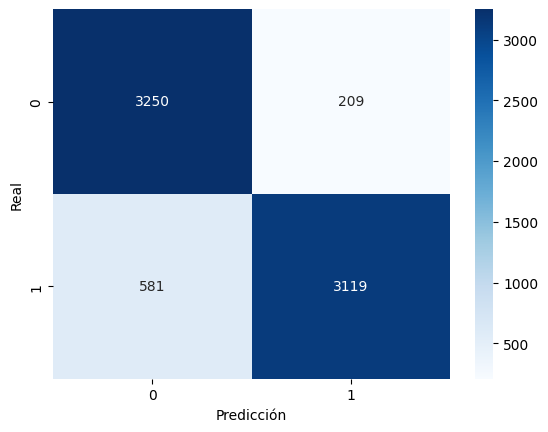

In [123]:
model_load = CustomModel()
evaluate_model(model_load, X_test, y_test)

#### **roBERTa Fine tunning with a dense classification head**

##### **Utils**

In [124]:
# Training function

def train(train_loader, optimizer, loss_function, model_train):
    loss = 0
    accuracy = 0
    batch_num = 0
    model_train.train()
    for batch in train_loader:
        batch_num += 1
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        y = batch["label"].to(device).float()
        output = model_train(input_ids, attention_mask)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_accuracy(output, y, len(train_loader.dataset))
    print(f"Train Loss: {round(loss/batch_num, 5)}, Train Accuracy: {round(accuracy, 5)}")

    return loss/batch_num, accuracy

In [125]:
# Validation function

def validate(val_loader, loss_function, model_val):

    loss = 0
    accuracy = 0
    batch_num = 0

    model_val.eval()
    with torch.no_grad():
        for batch in val_loader:
            batch_num += 1
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            y = batch["label"].to(device).float()
            output = model_val(input_ids, attention_mask)
            batch_loss = loss_function(output, y)

            loss += batch_loss.item()
            accuracy += get_accuracy(output, y, len(val_loader.dataset))
    print(f"Validation Loss: {round(loss/batch_num, 5)}, Validation Accuracy: {round(accuracy, 5)}")
    return loss/batch_num, accuracy

In [ ]:
# Model evaluation

def evaluate_model(model_load, test_loader):
    model_eval = load_checkpoint(model_load)
    batch = next(iter(test_loader))
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    y = batch["label"].cpu().float().numpy()

    with torch.no_grad():
        y_pred = model_eval(input_ids, attention_mask)

    pred = torch.sigmoid(y_pred).cpu().numpy() > 0.5

    print(classification_report(y, pred))

    conf_matrix = confusion_matrix(y, pred)

    sns.heatmap(conf_matrix, xticklabels = ["0", "1"], yticklabels = ["0", "1"], annot=True, cmap='Blues', fmt = 'g')
    plt.ylabel("Real")
    plt.xlabel("Predicción")
    plt.show()

In [ ]:
# Model evaluation without loading

def evaluate_model_no_load(model_eval, test_loader):
    batch = next(iter(test_loader))
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    y = batch["label"].cpu().float().numpy()
    model_eval.eval()
    with torch.no_grad():
        y_pred = model_eval(input_ids, attention_mask)

    pred = torch.sigmoid(y_pred).cpu().numpy() > 0.5

    print(classification_report(y, pred))

    conf_matrix = confusion_matrix(y, pred)

    sns.heatmap(conf_matrix, xticklabels = ["0", "1"], yticklabels = ["0", "1"], annot=True, cmap='Blues', fmt = 'g')
    plt.ylabel("Real")
    plt.xlabel("Predicción")
    plt.show()

In [ ]:
# Training loop

def training_loop(epochs, train_loader, val_loader, optimizer, loss_function, model_train_loop):
    max_accuracy = 0
    loss_accuracy_list = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss, train_accuracy = train(train_loader, optimizer, loss_function, model_train_loop)
        current_loss, val_accuracy = validate(val_loader, loss_function, model_train_loop)
        loss_accuracy_list.append((train_loss, train_accuracy, current_loss, val_accuracy))
        if max_accuracy < val_accuracy:
            max_accuracy = val_accuracy
            save_checkpoint(model_train_loop)
            print("Model saved!")
        else:
            print("Model not saved!")

    loss_accuracy_graph(loss_accuracy_list)

##### **Implementation**

In [129]:
# Setting the device to use GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

In [130]:
# Loading the data

data = pd.read_csv('balanced_data.csv')
X = data['tweet'].astype(str).values
y = data['class'].values

In [131]:
# Shuffling the dataset

permutation = np.random.permutation(len(y))
y = y[permutation].reshape(-1, 1)
X = X[permutation].tolist()

In [132]:
# Calculation of the set distribution

test_size = int(y.shape[0] * 0.15)
val_size = int(y.shape[0] * 0.15)
train_size = int(y.shape[0] * 0.7)

In [133]:
# Set definition

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size : ]
y_test = y[train_size + val_size : ]

In [134]:
# Custom dataset class

class CustomDatasetText(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return  {
            "input_ids": encoding["input_ids"].squeeze(0),         # shape: (seq_len)
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

    def __len__(self):
        return len(self.texts)

In [135]:
# Tokenizer and dataset definitions

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base")
train_set = CustomDatasetText(X_train, y_train, tokenizer, 32)
val_set = CustomDatasetText(X_val, y_val, tokenizer, 32)
test_set = CustomDatasetText(X_test, y_test, tokenizer, 32)

In [136]:
# Creation of the dataloaders

train_loader = DataLoader(train_set, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_set, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_set, batch_size = len(test_set), shuffle = False)

In [137]:
# BERT layer in our custom fine-tuned model

class BERTLayer(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        for param in self.roberta.parameters():
            param.requires_grad = False

    def activate_grad(self):
        for param in self.roberta.parameters():
            param.requires_grad = True

    def deactivate_grad(self):
        for param in self.roberta.parameters():
            param.requires_grad = False

    def forward(self,input_ids, attention_mask):
        outputs = self.roberta(input_ids= input_ids, attention_mask= attention_mask)
        return outputs.last_hidden_state[:,0,:]

In [ ]:
# Model architecture definition

class ClassificationHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(768, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.3)
        self.linear2 = nn.Linear(256, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p = 0.2)
        self.linear3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.linear3(x)

        return x


In [139]:
# Custom model definition

class CustomModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.bert = BERTLayer(model_name)
        self.head = ClassificationHead()

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids, attention_mask)
        x = self.head(x)
        return x

In [140]:
# Model instanciation

model_name = "cardiffnlp/twitter-roberta-base"
model = CustomModel(model_name)
model = torch.compile(model.to(device), backend="eager")
model

OptimizedModule(
  (_orig_mod): CustomModel(
    (bert): BERTLayer(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (out

In [141]:
# Loss and optimizer definition

loss_function = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters())
model = model.to(device)

              precision    recall  f1-score   support

         0.0       0.49      1.00      0.65      3477
         1.0       0.00      0.00      0.00      3682

    accuracy                           0.49      7159
   macro avg       0.24      0.50      0.33      7159
weighted avg       0.24      0.49      0.32      7159



/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



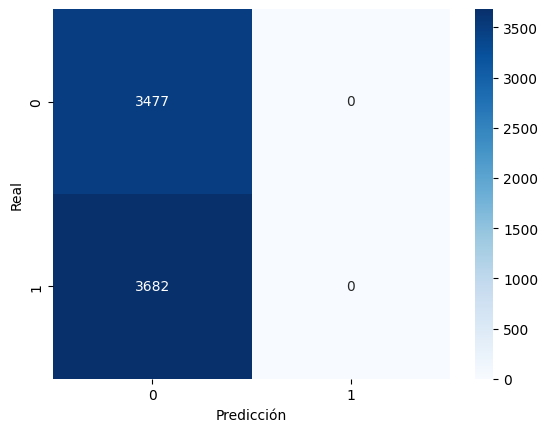

In [142]:
evaluate_model_no_load(model, test_loader)

In [143]:
training_loop(150, train_loader, val_loader, optimizer, loss_function, model)

Epoch 1/150
Train Loss: 0.41072, Train Accuracy: 0.82246
Validation Loss: 0.32974, Validation Accuracy: 0.85483
Model saved!
Epoch 2/150
Train Loss: 0.36885, Train Accuracy: 0.84024
Validation Loss: 0.32513, Validation Accuracy: 0.86014
Model saved!
Epoch 3/150
Train Loss: 0.36422, Train Accuracy: 0.84123
Validation Loss: 0.31708, Validation Accuracy: 0.8586
Model not saved!
Epoch 4/150
Train Loss: 0.35978, Train Accuracy: 0.8427
Validation Loss: 0.32363, Validation Accuracy: 0.85944
Model not saved!
Epoch 5/150
Train Loss: 0.35724, Train Accuracy: 0.84527
Validation Loss: 0.32158, Validation Accuracy: 0.85567
Model not saved!
Epoch 6/150
Train Loss: 0.35307, Train Accuracy: 0.84743
Validation Loss: 0.31162, Validation Accuracy: 0.86377
Model saved!
Epoch 7/150
Train Loss: 0.35173, Train Accuracy: 0.84485
Validation Loss: 0.31103, Validation Accuracy: 0.86265
Model not saved!
Epoch 8/150
Train Loss: 0.35238, Train Accuracy: 0.84632
Validation Loss: 0.31455, Validation Accuracy: 0.86167

KeyboardInterrupt: 

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87      3477
         1.0       0.91      0.83      0.86      3682

    accuracy                           0.87      7159
   macro avg       0.87      0.87      0.87      7159
weighted avg       0.87      0.87      0.87      7159



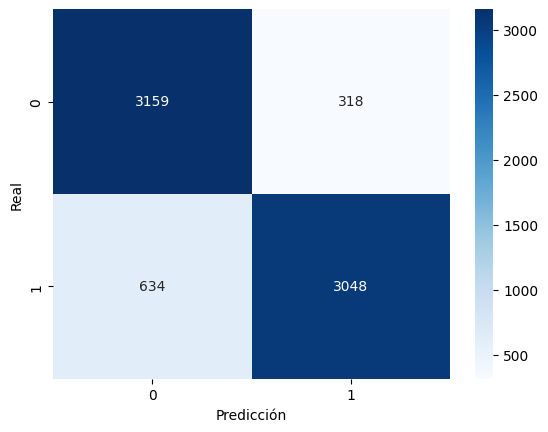

In [166]:
model_load = CustomModel(model_name)
evaluate_model(model_load, test_loader)

In [ ]:
# Unfreezing the model's weights

model_load.bert.activate_grad()
optimizer = Adam(model_load.parameters(), lr=.000001)

In [ ]:
training_loop(100, train_loader, val_loader, optimizer, loss_function, model_load)

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87      3477
         1.0       0.91      0.83      0.86      3682

    accuracy                           0.87      7159
   macro avg       0.87      0.87      0.87      7159
weighted avg       0.87      0.87      0.87      7159



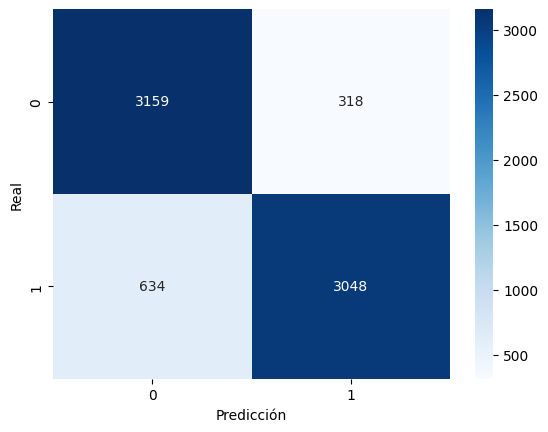

In [ ]:
model_load = CustomModel(model_name)
evaluate_model(model_load, test_loader)

### **Marilyn Stephany Joven Fonseca**

#### GRU

In [ ]:
# Loading embeddings from mpy
X = np.load('data/embeddings_data_glove.npy')

In [ ]:
# Loading labels from csv
df = pd.read_csv('data/balanced_data_glove.csv')
y = df['class'].to_numpy().astype(int)

assert X.shape[0] == y.shape[0], "Mismatch between embeddings and labels"


In [ ]:

# Removing classes with less than 2 items
class_counts = Counter(y)
valid_classes = {cls for cls, count in class_counts.items() if count >= 2}
mask = np.array([label in valid_classes for label in y])

X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# GRU definition
num_classes = len(np.unique(y_train))

model = Sequential([
    GRU(128, return_sequences=True, input_shape=(32, 100)),
    Dropout(0.3),
    GRU(32),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32)

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Predicting class probabilities
y_pred_prob = model.predict(X_test)
y_scores = y_pred_prob.ravel()

num_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=range(num_classes))


In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])  # [:,1] = prob of positive class
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob[:, 1])
avg_precision = average_precision_score(y_test, y_pred_prob[:, 1])

plt.figure()
plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


In [ ]:
input_seq = X_test[99].reshape(1, 32, 100)
pred_prob = model.predict(input_seq)[0][0]
pred_label = int(pred_prob > 0.50)
true_label = y_test[99]

In [ ]:
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42, stratify=y
)
original_index = idx_test[99]
tweet_text = df.iloc[original_index]['tweet']

In [ ]:
# Review examples from test
def inspect_model_decision(index, X_test, y_test, idx_test, df):
    input_seq = X_test[index].reshape(1, 32, 100)
    prob = model.predict(input_seq)[0][0]
    pred = int(prob < 0.5)
    true = y_test[index]
    original = idx_test[index]

    if isinstance(df, pd.DataFrame):
        tweet_text = df.iloc[original]['tweet']
    else:
        raise TypeError("Expected a DataFrame for df")

    print(f"\nTweet: {tweet_text}")
    print(f"True Label: {'HATE' if true else 'NOT HATE'}")
    print(f"Predicted: {'HATE' if pred else 'NOT HATE'} ({prob:.2f})")

df = pd.read_csv('data/balanced_data_glove.csv')
inspect_model_decision(55, X_test, y_test, idx_test, df)


### **Eder Leandro Carbonero Baquero**

#### CNN

In [157]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Cargar el archivo CSV
df_cnn = pd.read_csv('data/embeddings_data.csv')

# Asegurarse de que los embeddings son listas de números
X = np.array(df_cnn['embedding_mean'].apply(eval).tolist())  # Convertir de string a lista
y = np.array(df_cnn['class'])  # Etiquetas: 0 o 1

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Asegurarse de que los datos tengan la forma correcta (n_samples, sequence_length, n_channels)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Verificar las formas de los datos para asegurarse de que están correctos
print(X_train.shape, X_test.shape)


(38164, 768, 1) (9541, 768, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definir el modelo CNN con 5 capas
model = models.Sequential()

# Capa convolucional 1
model.add(layers.Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(layers.MaxPooling1D(2))

# Capa convolucional 2
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

# Capa convolucional 3
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

# Capa convolucional 4
model.add(layers.Conv1D(512, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

# Capa convolucional 5
model.add(layers.Conv1D(1024, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

# Aplanar los resultados
model.add(layers.Flatten())

# Capa densa de salida
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Salida binaria (0 o 1)

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


/Users/eventsequor/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [159]:
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping

# Configurar el entrenamiento
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 77s 79ms/step - accuracy: 0.7433 - loss: 0.4977 - precision: 0.7625 - recall: 0.7074 - val_accuracy: 0.8189 - val_loss: 0.4052 - val_precision: 0.9671 - val_recall: 0.6695
Epoch 2/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 78s 82ms/step - accuracy: 0.8446 - loss: 0.3568 - precision: 0.8916 - recall: 0.7895 - val_accuracy: 0.8387 - val_loss: 0.3581 - val_precision: 0.8435 - val_recall: 0.8415
Epoch 3/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 77s 81ms/step - accuracy: 0.8573 - loss: 0.3356 - precision: 0.9005 - recall: 0.8080 - val_accuracy: 0.8480 - val_loss: 0.3412 - val_precision: 0.8780 - val_recall: 0.8170
Epoch 4/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 75s 78ms/step - accuracy: 0.8616 - loss: 0.3200 - precision: 0.9024 - recall: 0.8155 - val_accuracy: 0.8542 - val_loss: 0.3361 - val_precision: 0.9181 - val_recall: 0.7855
Epoch 5/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 77s 80ms/step - accuracy: 0.8655 - loss: 0.3081 - precision: 0.9070 - recall: 0.8210 - val_accuracy: 0.8441 - va

In [160]:
# Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Umbral para clasificación binaria

# Calcular métricas adicionales
accuracy = model.evaluate(X_test, y_test)[1]
precision = tf.keras.metrics.Precision()(y_test, y_pred)
recall = tf.keras.metrics.Recall()(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8516 - loss: 0.3384 - precision: 0.9159 - recall: 0.7821
Accuracy: 0.8524263501167297
Precision: 0.9170462489128113
Recall: 0.7826887369155884
F1 Score: 0.8445572974166483


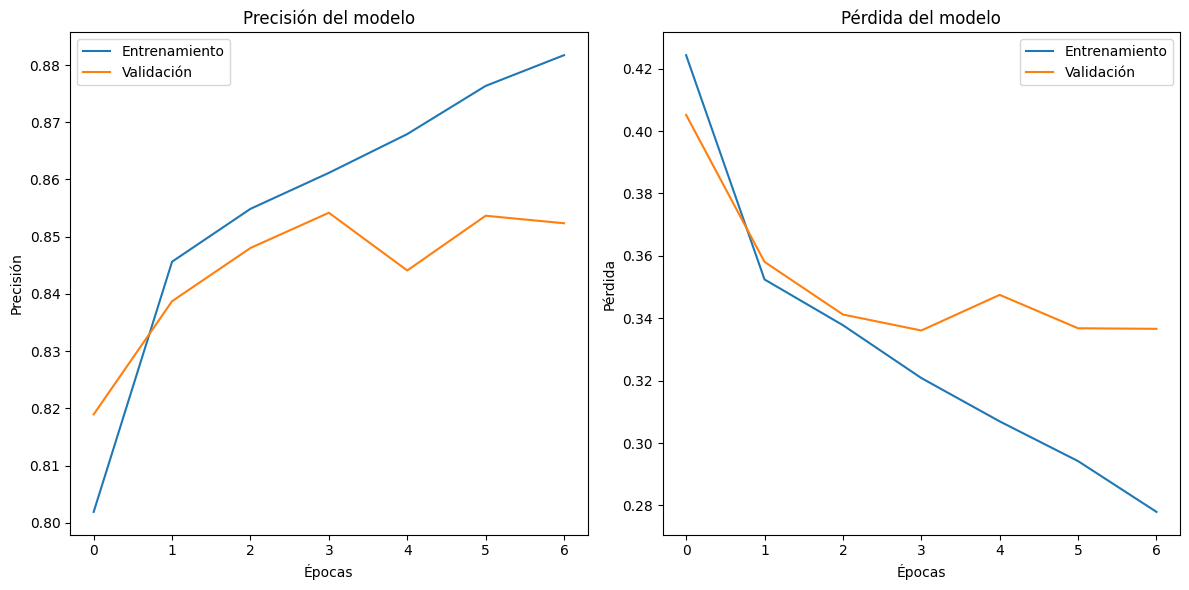

In [161]:
import numpy as np
import matplotlib.pyplot as plt

# Obtener las métricas de entrenamiento y validación
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Graficar la precisión
plt.figure(figsize=(12, 6))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

Guardar el modelo

In [162]:
# Guardar el modelo entrenado en un archivo
model.save('cnn_trained_model.h5')

Predicción dada una frase

In [ ]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import tensorflow as tf

# Cargar el tokenizador y el modelo de cardiffnlp/twitter-roberta-base
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base")
model_roberta = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-base")

# Función para obtener el embedding de un texto
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model_roberta(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

# Función para predecir si es hate speech
def predict_hate_speech(text, model):
    # Obtener el embedding del texto
    embedding = get_embedding(text)

    # Redimensionar el embedding para que tenga la forma adecuada
    embedding = embedding.reshape(1, -1)  # Forma (1, emb_size)

    # Asegurarse de que el modelo esté cargado correctamente
    if model is None:
        raise ValueError("El modelo no está cargado correctamente.")

    # Predicción con el modelo
    prediction = model.predict(embedding)

    # Clasificación: 0 = no hate speech, 1 = hate speech
    if prediction > 0.5:
        return "Hate Speech"
    else:
        return "No Hate Speech"

In [164]:
# Cargar el modelo previamente entrenado
model = tf.keras.models.load_model('cnn_trained_model.h5')  # Asegúrate de tener el modelo entrenado cargado
# Test de predicción
text = "bitch eat shit all day"  # Texto de ejemplo
result = predict_hate_speech(text, model)
print(f"Predicción: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicción: Hate Speech
